<a href="https://colab.research.google.com/github/Nataliaricotorres/ean_PNL/blob/main/clasificacion%20noticias/Modelos_RNN_LSTM(Noticias).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 curso PNL

__Integrantes del grupo__


*   Geraldine Patiño
*   Natalia Rico
*  Juan Sebastian Lozano

__Objetivo__

Clasificar noticias de acuerdo a su categoria mediante la implementacion de modelos de RNN y LSTM, para ello se debe realizar un preprocesamiento de los datos textuales, construir el modelo,  entrenarlo y evaluar cada uno con el fin de realizar una comparacion critica del rendimiento de ambos.

__Entregables__

**_Cuaderno Jupyther_** \
Proceso completo de preprocesamiento, construccion,entrenamiento, evaluacion y comparacion de modelo RNN y LSTM \
**_Informe_** \
Resumen de los hallazgos, comparacion de los modelos RNN y LSTM donde se tenga en cuenta las implicaciones practicas de los resultados.

> **Material de apoyo:** \
_El material de apoyo lo puede encontrar en https://github.com/Izainea/nlp_eanLinks to an external site. en la carpeta Cuadernos/Guia 2_



# Ejercicio 1.Carga y Exploración de Datos

**Objetivo:** Familiarizarse con el conjunto de datos y comprender la distribución de las categorías.\
Acciones:\
*  Cargar el archivo Noticias.xlsx que contiene las noticias.
*  Explorar la distribución de la columna Etiqueta para ver cuántas noticias pertenecen a cada categoría.
*  Visualizar esta distribución mediante gráficos para identificar las categorías más frecuentes.

Contexto:La columna Etiqueta en el conjunto de datos contiene categorías, algunas no especializadas o no tienen un enfoque específico (por ejemplo, "archivo"). \


> **Para esta actividad, nos centraremos en noticias de las categorías especializadas: deportes, cultura, economía y justicia**.
Estas categorías son relevantes porque representan temas con un enfoque claro y específico, lo que hace que la clasificación sea más útil y aplicable en el análisis de noticias.



In [ ]:
!pip install keras-nlp
!pip install tensorflow
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
# @title Importacion librerias utiles para la exploracion de los datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras

import tensorflow
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [ ]:
# @title Carga del archivo
# Descargar un archivo específico desde drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/PNL/act2noticias/'

filename = 'Noticias.xlsx'

data = pd.read_excel(f'{path}{filename}')
info = {'Data shape' : [data.shape],
        'Data info': [data.info()],
}

## Quitamos los nulos
data = data.dropna()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Columna1   14396 non-null  int64 
 1   Enlaces    14396 non-null  object
 2   Título     14378 non-null  object
 3   info       11483 non-null  object
 4   contenido  13738 non-null  object
 5   Etiqueta   14396 non-null  object
dtypes: int64(1), object(5)
memory usage: 674.9+ KB


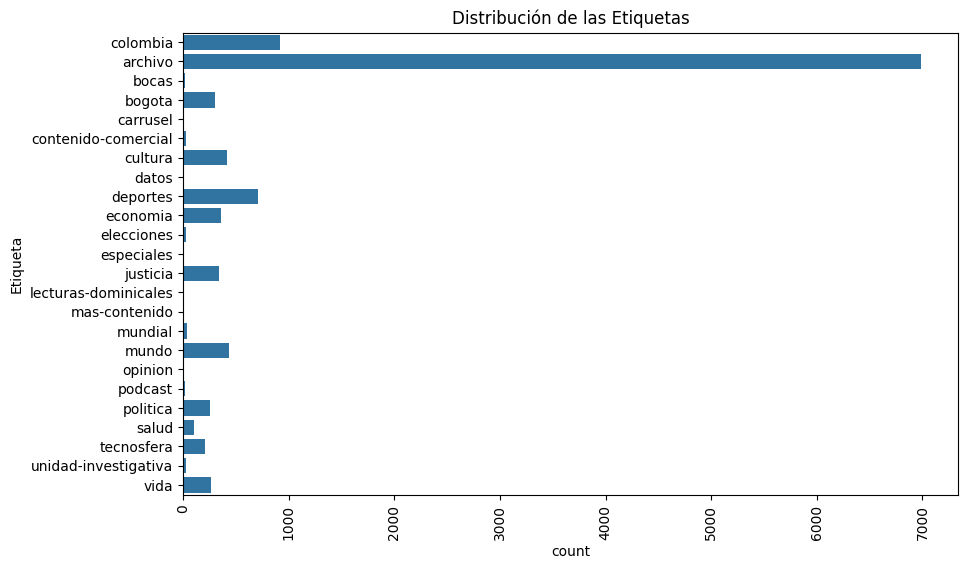

In [ ]:
# Visualizar la distribución de las etiquetas
plt.figure(figsize=(10, 6))
sns.countplot(data['Etiqueta'])
plt.title('Distribución de las Etiquetas')
plt.xticks(rotation=90)
plt.show()

Al revisar los resultados se puede ver que la clase mayoritaria corresponde a la etiqueta archivo, por lo cual no se trabaja con esta etiqueta, no nos da informacion para el objetivo del proyecto sin embargo se deja de trabajar con un gran numero de datos.
Tras filtrar el data set se revisa nuevamente la distribucion de datos.

# Ejercicio 2. Filtrado de Datos

__Objetivo:__ Limitar el conjunto de datos a las categorías relevantes para garantizar que el modelo se entrene y evalúe en temas especializados.\

__Acciones:__
Excluir las noticias que pertenecen a la categoría "archivo" y cualquier otra que no esté en las categorías de deportes, cultura, economía y justicia.
Asegurarse de que el conjunto de datos resultante tenga una distribución equilibrada para estas categorías, en la medida de lo posible.

__Contexto:__\
Es importante filtrar los datos para enfocarnos en temas especializados porque algunas categorías pueden tener un discurso amplio y no se tratan de un tema especializado. Esto ayuda a mejorar la precisión del modelo al enfocarse en categorías bien definidas.


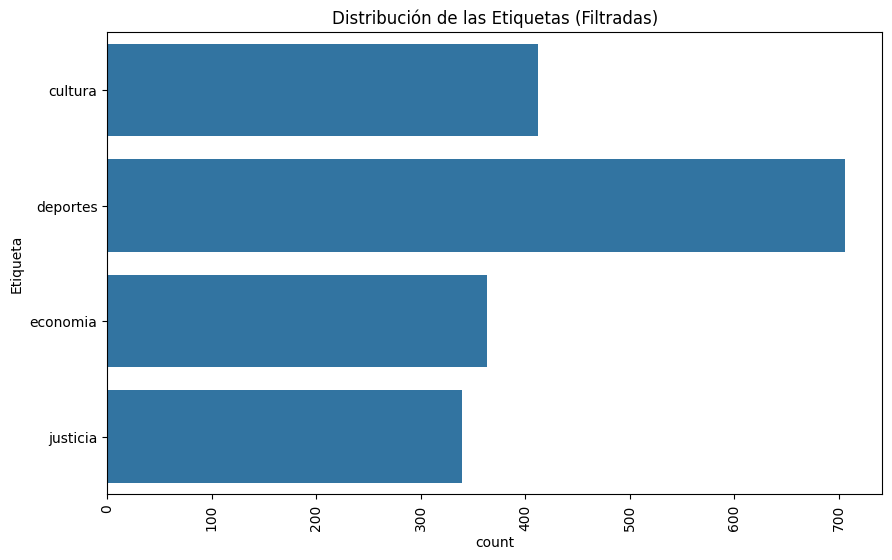

In [ ]:
# @title Proceso de limpieza de acuerdo a la categoria de las noticias

# Filtrar las categorías relevantes y excluir "archivo"
categorias_relevantes = ['deportes', 'cultura', 'economia', 'justicia']
data_filtrada = data[data['Etiqueta'].isin(categorias_relevantes)]

# Visualizar la distribución de las etiquetas después del filtrado
plt.figure(figsize=(10, 6))
sns.countplot(data_filtrada['Etiqueta'])
plt.title('Distribución de las Etiquetas (Filtradas)')
plt.xticks(rotation=90)
plt.show()

Se tiene que el mayor nuemro de noticias se organiza en la categoria de deportes, por lo cual se aplica un metodo de sobremuestreo para equilibrar las categorias y evitar que el modelo tome preferencia para las clases de mayor representacion.


# Ejercicio 3. Preprocesamiento de Texto

__**Objetivo:**__
 Preparar los datos textuales para el entrenamiento del modelo.\
__**Acciones:**__
*  Convertir todo el texto a minúsculas para uniformidad.
*  Eliminar puntuación y números para reducir el ruido en los datos.
*  Eliminar palabras comunes (stop words) que no aportan significado específico al análisis.
*  Tokenizar el texto, es decir, dividir el texto en palabras individuales.
*  Aplicar padding a las secuencias de palabras para que todas tengan la misma longitud, facilitando el procesamiento por las redes neuronales.

In [ ]:
# @title Proceso de preprocesamiento
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Función de preprocesamiento
def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation and not c.isdigit()])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('spanish')]
    return ' '.join(tokens)

# Aplicar preprocesamiento
data_filtrada['contenido_preprocesado'] = data_filtrada['contenido'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-13-fadccf87aa74>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrada['contenido_preprocesado'] = data_filtrada['contenido'].apply(preprocess_text)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Tokenizar el texto

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenización y padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_filtrada['contenido_preprocesado'])
sequences = tokenizer.texts_to_sequences(data_filtrada['contenido_preprocesado'])
word_index = tokenizer.word_index
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Mostrar algunas secuencias preprocesadas
padded_sequences[:5]

array([[ 1220, 19886,     6,   113,  1220, 27325,   318,  2949,     5,
         2880,     6,  6795,  6795,  7846, 27326,  1220,  2567,     5,
        27327,  1187,  7270,  4100,  1496,     6,   450,  7270, 27328,
         1772, 27329,   122,     5,   149,     6,   313, 27330,  1994,
          644,  7270,     5,    54,   313,  3326,  1600,   650,   954,
         4626, 11714,    24,     1,    46,    29,    17,    43,    38,
           47,    40,    15,    30,    39,    25,     7,    22,     4,
            1,    32,    31,    33,    23,    27,    45,    41,     2,
           13,    26,    50,     4,     1,    34,     8,    28,    21,
            9,    48,    12,     2,     1,    37,    42,    35,    16,
            3,    20,     1,    44,    11,    18,    19,    49,     3,
           36],
       [  220,    68,    69,    51,    92,   323,   215,  1708, 27354,
         9338,   178, 15995,  1253,   221,  4428,   239,   791,   215,
          180,    55,   726,  3526,  9346,    96,   410,  227

In [ ]:
Data_filtrado.head()

,Enlaces,Título,info,contenido,Etiqueta,Contenido_preprocesado
8259,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,citas “los crímenes de violencia sexual cometi...
8260,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,con motivo de la celebración de los años de l...
8261,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura,el cuadro busto de mujer del artista español p...
8262,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura,el carnaval de las artes organizado en barranq...
8263,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura,louise du toit filósofa el doctor denis mukweg...


In [ ]:
datos_balanceados.head()

,Enlaces,Título,info,contenido,Etiqueta,Contenido_preprocesado
8775,https://www.eltiempo.com/deportes/ciclo-olimpi...,¿Mujer araña? Así entrena para Olímpicos en su...,"Utiliza las paredes, la cocina y la sala para ...",Brooke Raboutou es una escaladora estadouniden...,deportes,brooke raboutou es una escaladora estadouniden...
9108,https://www.eltiempo.com/deportes/futbol-inter...,"James, campeón de la ‘Champlay’: ¡goleando al ...",El colombiano participó en un torneo virtual c...,Los juegos de video dan para curiosidades como...,deportes,los juegos de video dan para curiosidades como...
8943,https://www.eltiempo.com/deportes/futbol-colom...,"Tolima, a asegurar la clasificación a los cuar...",El equipo campeón de Alberto Gamero tiene 29 p...,Ante su afición y tomando en cuenta lo apretad...,deportes,ante su afición y tomando en cuenta lo apretad...
8779,https://www.eltiempo.com/deportes/ciclo-olimpi...,La decisión que tomó Donald Trump sobre los Ju...,El presidente de Estados Unidos fue claro en e...,"El presidente de los EE. UU., Donald Trump, ap...",deportes,el presidente de los ee uu donald trump apoyo ...
8744,https://www.eltiempo.com/deportes/ciclismo/pat...,Etapa y liderato para Bevin en el Tour Down Under,Le dio el primer triunfo del 2019 al nuevo equ...,Patrick Bevin (CCC) aprovechó el enredón en el...,deportes,patrick bevin ccc aprovechó el enredón en el ú...


# Ejercicio 4.División del Conjunto de Datos

__**Objetivo:**__ Crear conjuntos de datos de entrenamiento y validación para evaluar el modelo.\
__**Acciones:**__
Dividir el conjunto de datos preprocesado en dos partes: uno para entrenar el modelo y otro para validarlo.\
Asegurarse de que la división sea aleatoria, pero que mantenga una proporción similar de las categorías en ambos conjuntos.

In [ ]:
# @title PARTICION DEL CONJUNTO DE DATOS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Codificación de etiquetas
label_encoder = LabelEncoder()
data_filtrada['Etiqueta_codificada'] = label_encoder.fit_transform(data_filtrada['Etiqueta'])

# División del conjunto de datos
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, data_filtrada['Etiqueta_codificada'], test_size=0.2, random_state=42)

# Mostrar tamaño de los conjuntos de datos
len(X_train), len(X_val)

<ipython-input-18-a885d0e71539>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrada['Etiqueta_codificada'] = label_encoder.fit_transform(data_filtrada['Etiqueta'])


(1456, 364)

# Ejercicio 5.Implementación de un Modelo RNN

__**Objetivo:**__ Construir y entrenar un modelo RNN para clasificar las noticias.\
__**Acciones:**__
*  Definir la arquitectura del modelo RNN, incluyendo capas de embedding y capas recurrentes.
*  Configurar los hiperparámetros del modelo, como el tamaño del embedding y el número de unidades recurrentes.
*  Entrenar el modelo utilizando el conjunto de datos de entrenamiento y evaluar su rendimiento en el conjunto de validación.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.3198 - loss: 1.3763 - val_accuracy: 0.5027 - val_loss: 1.1727
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.8317 - loss: 0.7157 - val_accuracy: 0.7720 - val_loss: 0.6656
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9932 - loss: 0.1085 - val_accuracy: 0.7143 - val_loss: 0.8297
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.7637 - val_loss: 0.7777
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.7720 - val_loss: 0.8116
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.7830 - val_loss: 0.8187
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7885 - val_loss: 0.8457
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.7

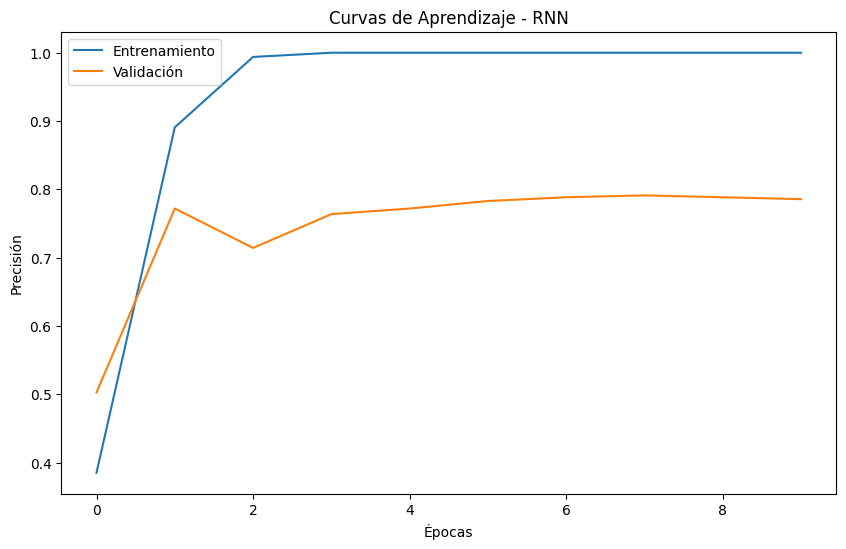

In [ ]:
# @title CONSTRUCCION MODELO RNN
from sklearn.metrics import accuracy_score, f1_score, recall_score
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

# Construcción del modelo RNN

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=128,
                        input_length=max_len))
model_rnn.add(SimpleRNN(units=64, return_sequences=False))
model_rnn.add(Dense(units=len(categorias_relevantes), activation='softmax'))

# Compilación del modelo
model_rnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entrenamiento del modelo
history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Predecir en el conjunto de validación
y_pred = model_rnn.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Calcular las métricas
accuracy = accuracy_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes, average='weighted')  # Use weighted average for multi-class
recall = recall_score(y_val, y_pred_classes, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")


# Visualización de resultados del modelo RNN
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['accuracy'], label='Entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curvas de Aprendizaje - RNN')
plt.show()

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.4299 - loss: 2.2829 - val_accuracy: 0.5110 - val_loss: 1.9903
Epoch 2/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.7917 - loss: 1.5925 - val_accuracy: 0.6401 - val_loss: 1.5431
Epoch 3/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.9515 - loss: 1.0516 - val_accuracy: 0.7115 - val_loss: 1.3599
Epoch 4/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - accuracy: 0.9973 - loss: 0.6873 - val_accuracy: 0.6896 - val_loss: 1.3164
Epoch 5/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 1.0000 - loss: 0.5124 - val_accuracy: 0.6813 - val_loss: 1.3220
Epoch 6/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 1.0000 - loss: 0.4039 - val_accuracy: 0.6593 - val_loss: 1.3324
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Accuracy: 0.6895604395604396
F1 Score: 0.6834877236651429
Recall: 0.6895604395604396


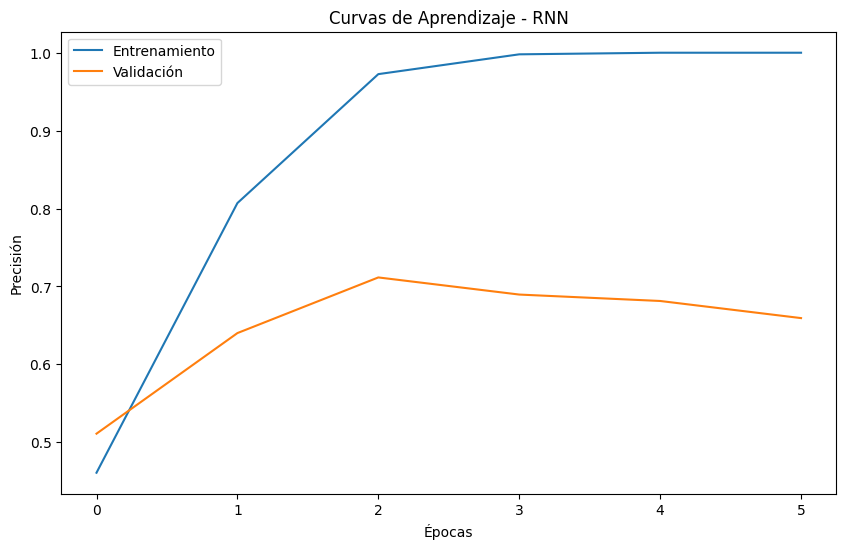

In [ ]:
# @title MODIFCICACION MODELO
from sklearn.metrics import accuracy_score, f1_score, recall_score
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

# Construcción del modelo RNN

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(word_index) + 1, output_dim=300, input_length=max_len))
model_rnn.add(SimpleRNN(units=64, return_sequences=False, kernel_regularizer=l2(0.01)))
#model_rnn.add(Dropout(0.3))  # Dropout de 50%
model_rnn.add(Dense(units=len(categorias_relevantes), activation='softmax'))
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilación del modelo
optimizer = Adam(learning_rate=0.0005)
model_rnn.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo

history_rnn = model_rnn.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=6, batch_size=32, callbacks=[early_stopping])

# Predecir en el conjunto de validación
y_pred = model_rnn.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Calcular las métricas
accuracy = accuracy_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes, average='weighted')  # Use weighted average for multi-class
recall = recall_score(y_val, y_pred_classes, average='weighted')
# Calcular las métricas
accuracy = accuracy_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes, average='weighted')  # Use weighted average for multi-class
recall = recall_score(y_val, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Visualización de resultados del modelo RNN
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['accuracy'], label='Entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curvas de Aprendizaje - RNN')
plt.show()

# Ejercicio 6.Implementación de un Modelo LSTM

__**Objetivo:**__ Construir y entrenar un modelo LSTM para clasificar las noticias.\
__**Acciones:**__
*  Definir la arquitectura del modelo LSTM, que incluye celdas LSTM diseñadas para manejar dependencias a largo plazo más eficientemente.
*  Configurar los hiperparámetros del modelo, similar al proceso del modelo RNN.
*  Entrenar el modelo LSTM y evaluar su rendimiento utilizando los mismos conjuntos de datos.

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.3621 - loss: 3.7180 - val_accuracy: 0.3709 - val_loss: 2.7201
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/step - accuracy: 0.3920 - loss: 2.4875 - val_accuracy: 0.3709 - val_loss: 1.9990
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.3854 - loss: 1.8775 - val_accuracy: 0.3709 - val_loss: 1.6323
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 419ms/step - accuracy: 0.3821 - loss: 1.5767 - val_accuracy: 0.3709 - val_loss: 1.4684
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.3793 - loss: 1.4292 - val_accuracy: 0.4670 - val_loss: 1.0874
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Accuracy: 0.46703296703296704
F1 Score: 0.3921132464471402
Recall: 0.46703296703296704


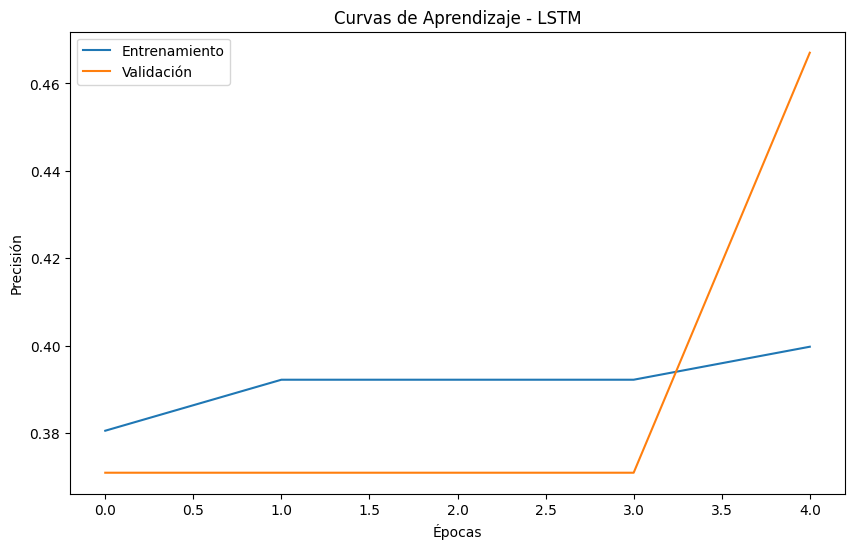

In [ ]:
# @title Modelo LSTM
from keras.layers import LSTM

# Construcción del modelo

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(word_index) + 1, output_dim=300, input_length=max_len))
model_lstm.add(LSTM(units=64, return_sequences=False, kernel_regularizer=l2(0.01)))
#model_lstm.add(Dropout(0.3))  # Dropout de 50%
model_lstm.add(Dense(units=len(categorias_relevantes), activation='softmax'))
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilación del modelo
optimizer = Adam(learning_rate=0.0005)
model_lstm.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Entrenamiento del modelo

history_lstm = model_lstm.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[early_stopping])

# Predecir en el conjunto de validación
y_pred = model_lstm.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Calcular las métricas
accuracy = accuracy_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes, average='weighted')  # Use weighted average for multi-class
recall = recall_score(y_val, y_pred_classes, average='weighted')
# Calcular las métricas
accuracy = accuracy_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes, average='weighted')  # Use weighted average for multi-class
recall = recall_score(y_val, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Visualización de resultados del modelo RNN
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Entrenamiento')
plt.plot(history_lstm.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curvas de Aprendizaje - LSTM')
plt.show()

# Ejercicio 7.Comparación de Resultados

__**Objetivo:**__ Evaluar y comparar el rendimiento de los modelos RNN y LSTM.\
__**Acciones:**__
*  Calcular y comparar métricas de rendimiento como precisión, recall y F1-score para ambos modelos.
*  Visualizar las curvas de aprendizaje y los resultados de validación para entender mejor cómo se desempeñan los modelos en las tareas de clasificación.
*  Comparar los modelos permite entender las fortalezas y debilidades de cada enfoque, proporcionando información valiosa para elegir el modelo más adecuado para tareas específicas de clasificación de texto.
*  Documentar estos resultados de forma asertiva en el cuaderno y en el informe.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RNN Classification Report:
              precision    recall  f1-score   support

    deportes       0.50      0.44      0.47        79
     cultura       0.86      0.90      0.88       135
    economia       0.57      0.74      0.64        78
    justicia       0.72      0.50      0.59        72

    accuracy                           0.69       364
   macro avg       0.66      0.65      0.65       364
weighted avg       0.69      0.69      0.68       364

LSTM Classification Report:
              precision    recall  f1-score   support

    deportes       0.00      0.00      0.00        79
     cultura       0.95      0.73      0.83       135
    economia       0.00      0.00      0.00        78
    justicia       0.27      0.99      0.43        72

    accuracy                           0.47       364
   macro avg       0.31      0.43      0.31       364
weighted avg       0.41      0.47      0.39       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


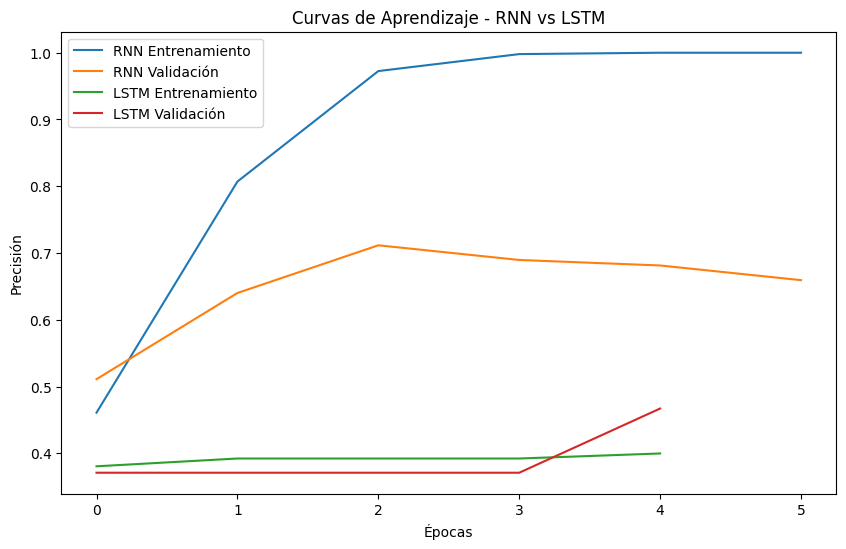

In [ ]:
# @title Comparacion de metricas de rendimiento
from sklearn.metrics import classification_report
# Evaluar modelos en el conjunto de validación
y_pred_rnn = model_rnn.predict(X_val).argmax(axis=1)
y_pred_lstm = model_lstm.predict(X_val).argmax(axis=1)

# Calcular métricas de rendimiento
report_rnn = classification_report (y_val, y_pred_rnn, target_names=categorias_relevantes)
report_lstm = classification_report (y_val, y_pred_lstm, target_names=categorias_relevantes)

print("RNN Classification Report:")
print(report_rnn)

print("LSTM Classification Report:")
print(report_lstm)

# Visualización de resultados
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['accuracy'], label='RNN Entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validación')
plt.plot(history_lstm.history['accuracy'], label='LSTM Entrenamiento')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curvas de Aprendizaje - RNN vs LSTM')
plt.show()

# Ejercicio 8.Evaluación y Conclusiones

_Desarrollado en: https://github.com/Nataliaricotorres/ean_PNL/blob/main/clasificacion%20noticias/Modelo_Bert_e_Informe.ipynb especificamente pto 5.